In [1]:
import numpy as np
import torch
import pandas as pd
import os
import glob
from pathlib import Path
from scipy.io import loadmat
from typing import Pattern, List , Union
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
DATASET = 'UTD_MAAD'
ROOT_DIR = "/home/bgu9/Fall_Detection_KD_Multimodal"
PATTERN = r'a\d+'
LABEL_PATTERN = r'\d+'

In [3]:
def create_label(pattern : Pattern, label_pattern : Pattern, path : List[Union[Path,str]]) -> int:
    '''
    Function to create label for file path

    Arguements: 
        pattern : patterns to find in path 
        label_pattern : label pattern
        path : file path

    Output:
        Label 

    '''
    #labels = []
    # for path in path_list: 
    prog = re.compile(pattern)
    result = prog.findall(path)[0]
    act_prog =re.compile(label_pattern)
    label = int(act_prog.findall(result)[0])
    #labels.append(label)
    return label

In [4]:

def resample_data(old_rate: int , new_rate: int, dataset: List[np.ndarray]) ->  List[np.ndarray]:
    '''
    Function to change sampling rate of the data
    Arguements: 
        old_rate : exisiting sampling rate
        new_rate : new sampling rate
        data : data to resample
    Output: 
        interpolated data : data resampled to new sampling rate
    ''' 
    
     # Generate the time array based on sampling rate
    resampled_dataset = []
    for data in dataset:
        time = np.arange(0, data.shape[0]) / old_rate

        # Create interpolation functions for each dimension
        interp_functions = [interp1d(time, data[:, i], kind='linear') for i in range(data.shape[-1])]

        # Define new time array for interpolated data
        new_length = int(data.shape[0]*(new_rate/old_rate))
        new_time = np.arange(0, new_length)/ new_rate # Assuming you want to interpolate at 100Hz

        # Interpolate data for each dimension using the interpolation functions
        interpolated_data = np.column_stack([f(new_time) for f in interp_functions])
        resampled_dataset.append(interpolated_data)

    return resampled_dataset

In [5]:
def load_file(path_list: List[Union[Path,str]], **kwargs):
    '''
    Function to load files with different extension

    Arguement: 
        path: path to load
    '''
    dataset = []
    for path in path_list:
        _, file_extension = os.path.splitext(path)

        if file_extension == '.npy':
            data = np.load(path)

        else: 
            assert 'key' in kwargs.keys() , f"File is {file_extension} type, need to provide the key "
            data  =  loadmat(path)[kwargs['key']]
            data = data.reshape(-1, 20, 3)
        dataset.append(data)
    return dataset

In [6]:
# ploting normalitiy
def find_all_path(pattern : Pattern, paths : List[Union[Path,str]]) -> List[str] :
    '''
        Function to find files specific to an activity

        Arguement:
            pattern : pattern related to the activity
            paths: List of paths

        Output : List of activity paths
    ''' 

    activity_path = [path for path in paths if re.findall(pattern=pattern, string=path)]
    return activity_path

# find all files of the same activity 
# def find_all(p)

In [8]:
def merge_data(activity_path : List[Union[Path,str]], axis = None, **kwargs):
    '''
        Funciton to merge all data in one array 
        Arguements: 
            
    '''
    arrays = load_file(activity_path, **kwargs)
    concatenated_array = np.concatenate(arrays, axis = axis)
    return concatenated_array


In [9]:
def axis_plot(data: np.ndarray, axis : int = None , num_col : int = 4 ) : 
    '''
    
    '''
    plt.figure(figsize=(24, 24))
    axis_len = data.shape[axis]
    num_row = (axis_len // num_col ) + 1
    for i in range(axis_len) :
        plt.subplot(num_row, num_col, i+1)
        color = plt.cm.viridis(i / data.shape[axis])
        plt.hist(data[:, i], bins = 30, alpha = 0.5, label = f'Axis {i + 1}', color = color)
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.title('Distribution along axis {}'.format(i+1))
        plt.grid()
        plt.legend()

In [10]:
def get_pathlist(root_dir:str = "/home/bgu9/Fall_Detection_KD_Multimodal", dataset:str = 'UTD_MAAD', modality :str = 'skeloton') ->  List[str]: 
    '''
    Function to get all files of a modality
    Arguement: 
        root_dir : Root directory 
        dataset :  dataset 
        modality: inertial or skeleotn
    
    Output: list of file path of specific modality
    '''

    return glob.glob(f'{root_dir}/data/{dataset}/{modality}/*')

In [11]:
def sliding_window(data, clearing_time_index, max_time, sub_window_size, stride_size):

    assert clearing_time_index >= sub_window_size - 1 , "Clearing value needs to be greater or equal to (window size - 1)"
    start = clearing_time_index - sub_window_size + 1 

    if max_time >= data.shape[0]-sub_window_size:
        max_time = max_time - sub_window_size + 1
        # 2510 // 100 - 1 25 #25999 1000 24000 = 24900

    sub_windows  = (
        start + 
        np.expand_dims(np.arange(sub_window_size), 0) + 
        np.expand_dims(np.arange(max_time, step = stride_size), 0).T
    )

    #labels = np.round(np.mean(labels[sub_windows], axis=1))
    return data[sub_windows] 



In [12]:
def process_data(dataset, window_size, stride):
    # dataframe = pd.read_csv(file_path)
    # raw_data = dataframe[['w_accelerometer_x', 'w_accelerometer_y', 'w_accelerometer_z']].to_numpy()
    # labels = dataframe['outcome'].to_numpy()
    window_set = []
    for data in dataset: 
        processed_window = sliding_window(data, window_size - 1,data.shape[0],window_size,stride)
        window_set.append(processed_window)
    return window_set


In [13]:
def create_win_label(win_list:List[np.ndarray], label_list:List[int]) -> List[np.ndarray]: 
    win_label = []
    for (data , label) in zip(win_list, label_list): 
        total_win = data.shape[0]
        win_label.append(np.repeat(label, total_win))
    return win_label

        

In [14]:
# load inertial file
DATASET = 'UTD_MAAD'
ROOT_DIR = "/home/bgu9/Fall_Detection_KD_Multimodal"
PATTERN = r'A\d+'
LABEL_PATTERN = r'\d+'

def create_dataset(name : str = DATASET, root_dir : Union[Path, str] = ROOT_DIR, need_label : bool = True, 
                    pattern :Pattern = PATTERN, label_pattern:Pattern = LABEL_PATTERN, 
                    window_size:int = 32, stride:int = 16, key = 'd_skel'):
    
    '''
    Function to create dataset
    Arguements:
        name: name of the dataset
        root_dir: root directory of the dataset
        need_label: Needs label or not
        pattern : Activity Pattern to detect
        label_pattern: Label Pattern
    '''

    # get all inertial path 
    path_list = get_pathlist(modality = 'skeleton')
    # load data 
    data_list = load_file(path_list, key = key)
    print(data_list[0].shape)
    
    #resampled_data = resample_data(old_rate=50, new_rate=30, dataset = data_list)
    #resample dataset 
    window_set = process_data(dataset=data_list, window_size=32, stride = 16)
    file_label = create_label(pattern, label_pattern, path_list)
    label_set = create_win_label(window_set, file_label)
    window_dataset = np.concatenate(window_set, axis = 0)
    #label_dataset = np.concatenate(label_set, axis = 0)

    return window_dataset, label_set

#

#get all skeleton path
# keleton_path = get_pathlist(modality = 'skeleton')
# norm_iner = inertial_scaler.fit_transform(resampled_data)



In [17]:
window_data, label_dataset = create_dataset()
print(window_data.shape)
# print(label_dataset.shape)

(68, 20, 3)
(505, 32, 20, 3)


In [19]:
# load skeleton file
modality = 'skeleton'


#skeleton_op_len = {}
skeleton_len = {}
skeleton_list = glob.glob('data/smartfallmm/old_participant/skeleton/**')
old_list = glob.glob('data/smartfallmm/student/skeleton/**')
combined_list = skeleton_list + old_list
PATTERN = r'A\d+'
LABEL_PATTERN = r'\d+'

for skeleton_path in combined_list:
    #skeleton_data = loadmat(skeleton_path)['d_skel']
    skeleton_data =  pd.read_csv(skeleton_path)
    label = create_label(PATTERN, LABEL_PATTERN, skeleton_path)

    if label not in skeleton_len: 
        skeleton_len[label] =  []
    #print("Activity: {}  Length: {}".format(label, skeleton_data.shape[2]))
    skeleton_len[label].append(skeleton_data.shape[0])
skeleton_len = dict(sorted(skeleton_len.items()))
#print("------------ Openpose ---------------")
# for skeleton_path_op in skeleton_op_list:
#     skeleton_data_op = np.load(skeleton_path_op)
#     label_op = create_label(pattern, label_pattern, skeleton_path_op)
#     if label_op not in skeleton_op_len:
#         skeleton_op_len[label_op] = []
#     skeleton_op_len[label_op].append(skeleton_data_op.shape[0])
# skeleton_op_len = dict(sorted(skeleton_op_len.items()))
    #print("Activity: {}  Length: {}".format(label, skeleton_data_op.shape[0]))
# reshaped_data = skeleton_data.reshape((skeleton_data.shape[2], -1))[: , 33]
# reshaped_data = reshaped_data[: , np.newaxis]

# skeleton_scaler = MinMaxScaler()

# norm_skel = skeleton_scaler.fit_transform(reshaped_data)

In [22]:
skeleton_len.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

In [10]:
activities = {
    'drink' : 1,
    'pickup' : 2, 
    'put_onoff' : 3, 
    'stepup' : 4,
    'sweep' : 5,
    'wash':6,
    'wave' : 7, 
    'walk':8,
    'sit':9, 
    'back_fall':10,
    'front_fall':11, 
    'left_fall':12,
    'right_fall':13,
    'rotate_fall':14
}


activity_map  = {}

for key , values in activities.items():
    activity_map[values] = key

In [11]:
activity_map

{1: 'drink',
 2: 'pickup',
 3: 'put_onoff',
 4: 'stepup',
 5: 'sweep',
 6: 'wash',
 7: 'wave',
 8: 'walk',
 9: 'sit',
 10: 'back_fall',
 11: 'front_fall',
 12: 'left_fall',
 13: 'right_fall',
 14: 'rotate_fall'}

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

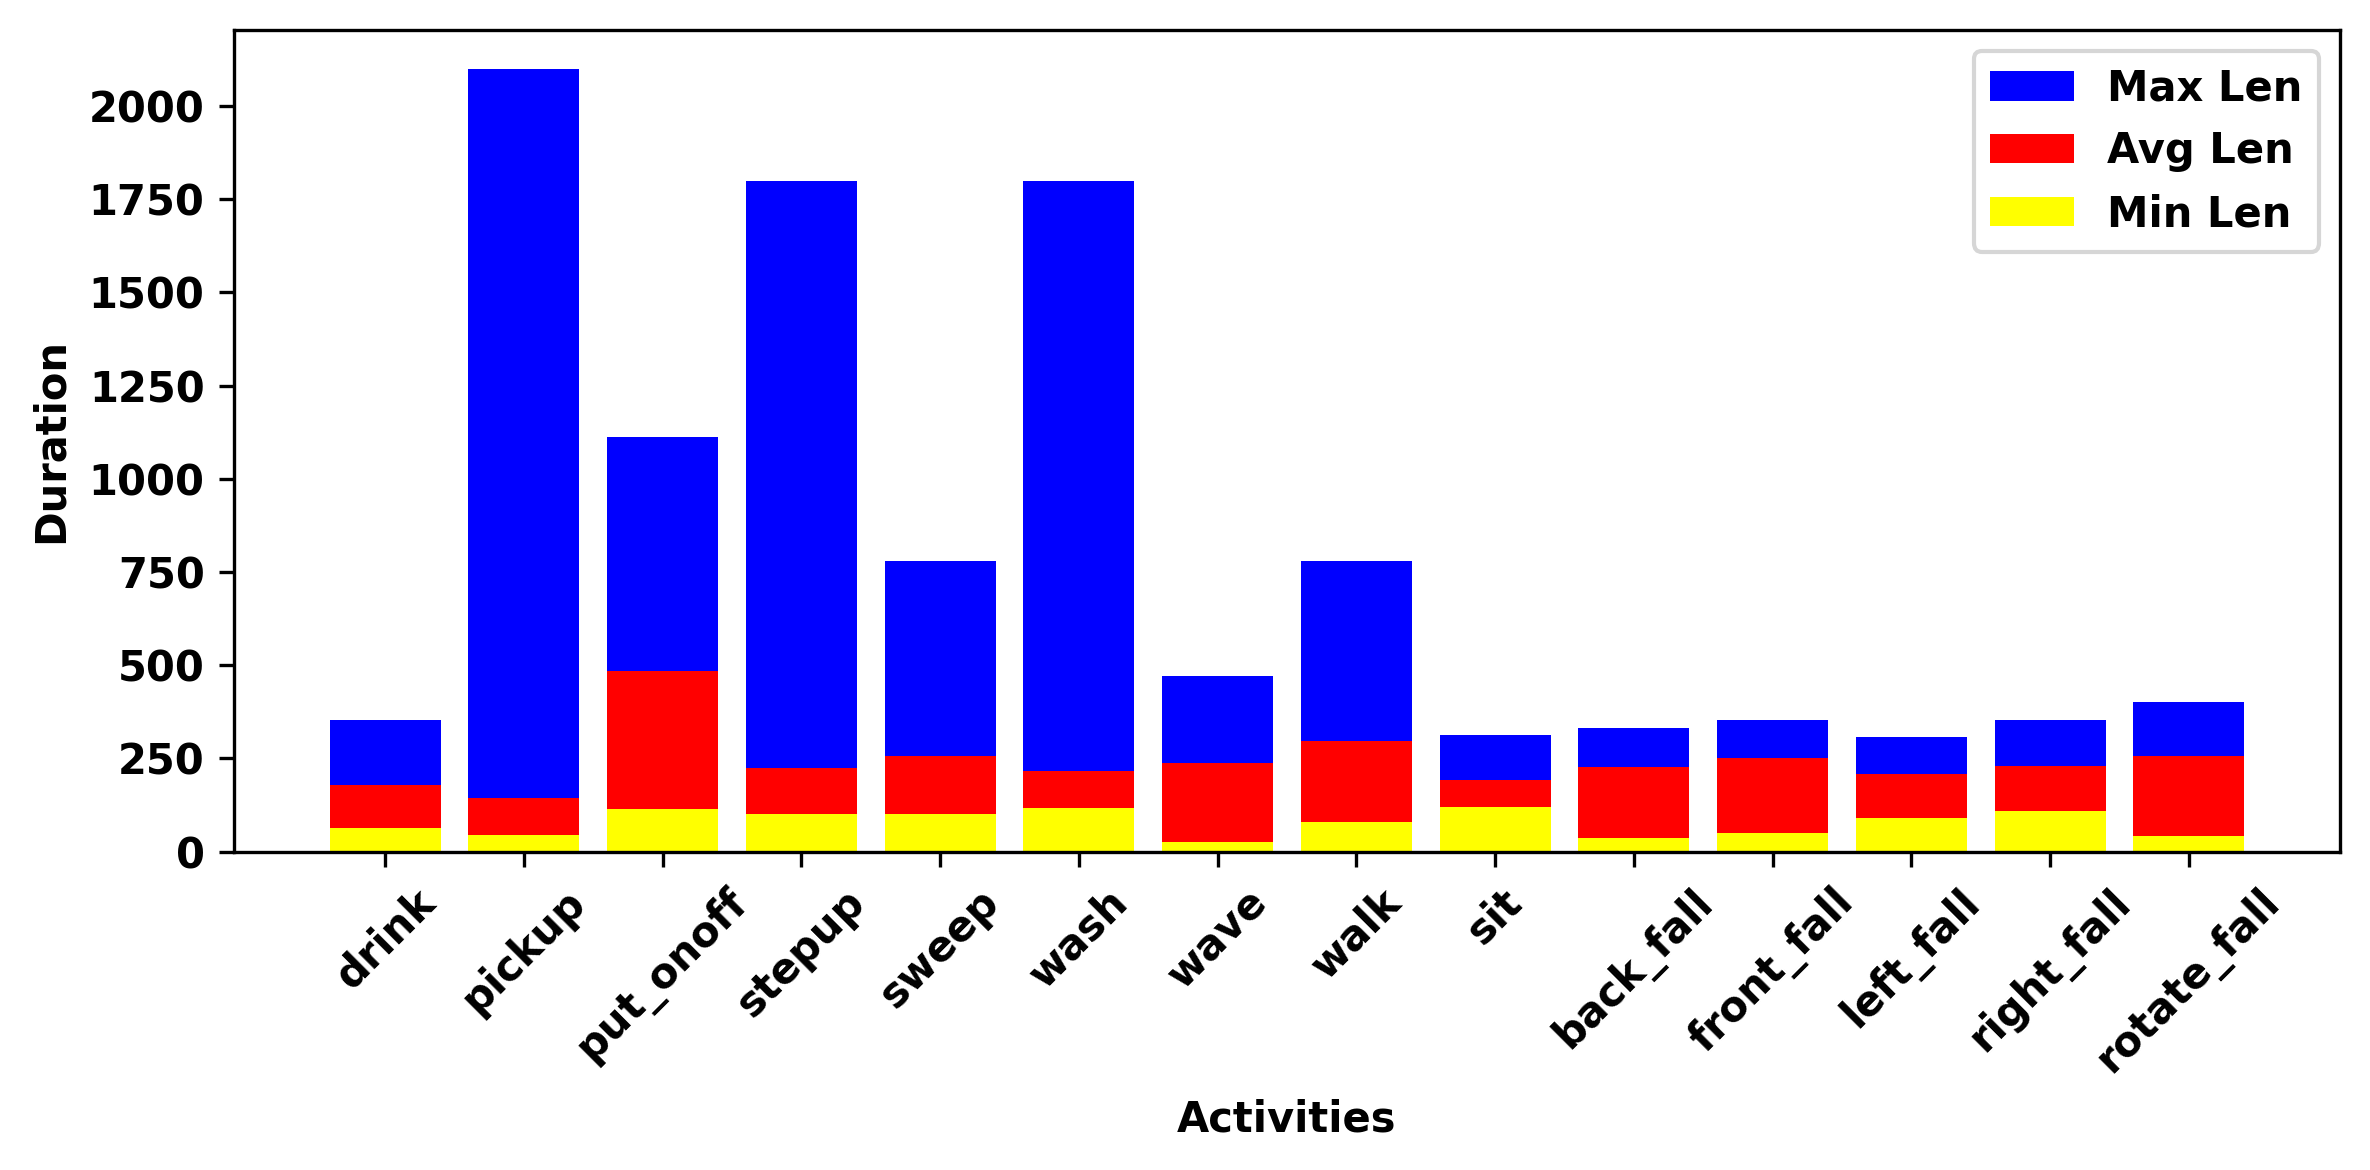

In [48]:
import matplotlib.pyplot as plt

# Define the dictionaries

# Combine values for identical keys into separate lists
#data1 = [skeleton_op_len[key] for key in skeleton_op_len]

data2 = [skeleton_len[key] for key in skeleton_len]
# trigger core fonts for PDF backend
plt.rcParams["pdf.use14corefonts"] = True
# trigger core fonts for PS backend
plt.rcParams["ps.useafm"] = True
plt.rcParams['font.weight'] = 'bold'
# Create a list of keys
keys = list(activity_map.values())
x = np.arange(len(keys))
# Create boxplot
# fig , ax = plt.figure(figsize = (24, 6))
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(4)
fig.set_dpi(300)
categories = keys
values_mean = [int(sum(array) / len(array)) for array in data2]
values_min = [min(array) for array in data2]
values_max = [max(array) for array in data2]

# weight_count = {}
# for key, value in activity_map.items():
#     weight_count[value] = np.arrary([values_mean[value], values_min[value], values_max[value]]) 



# bottom = np.zeros(14)
bar3 = ax.bar(x, values_max, label = 'Max Len', color = 'blue')
bar1 = ax.bar(x ,values_mean, label = 'Avg Len', color = 'red')
bar2 = ax.bar(x, values_min, label = 'Min Len', color = 'yellow')


# plt.boxplot(data2, positions=[i-0.2 for i in range(1, len(keys)+1)], widths=0.4, patch_artist=True, boxprops=dict(facecolor='skyblue'))
#plt.boxplot(data2, positions=[i+0.2 for i in range(1, len(keys)+1)], widths=0.4, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
ax.set_ylabel('Duration', fontweight = 'bold')
ax.set_xticks(x)
ax.set_xticklabels(keys, rotation = 45)
plt.tight_layout()
plt.legend()
plt.savefig('Average_activity_length.pdf')


In [101]:
act_path_skel = find_all_path(r'a17', skeleton_list)
act_path_op = find_all_path(r'a17', skeleton_op_list)

In [ ]:
def distribution_comparision(data)

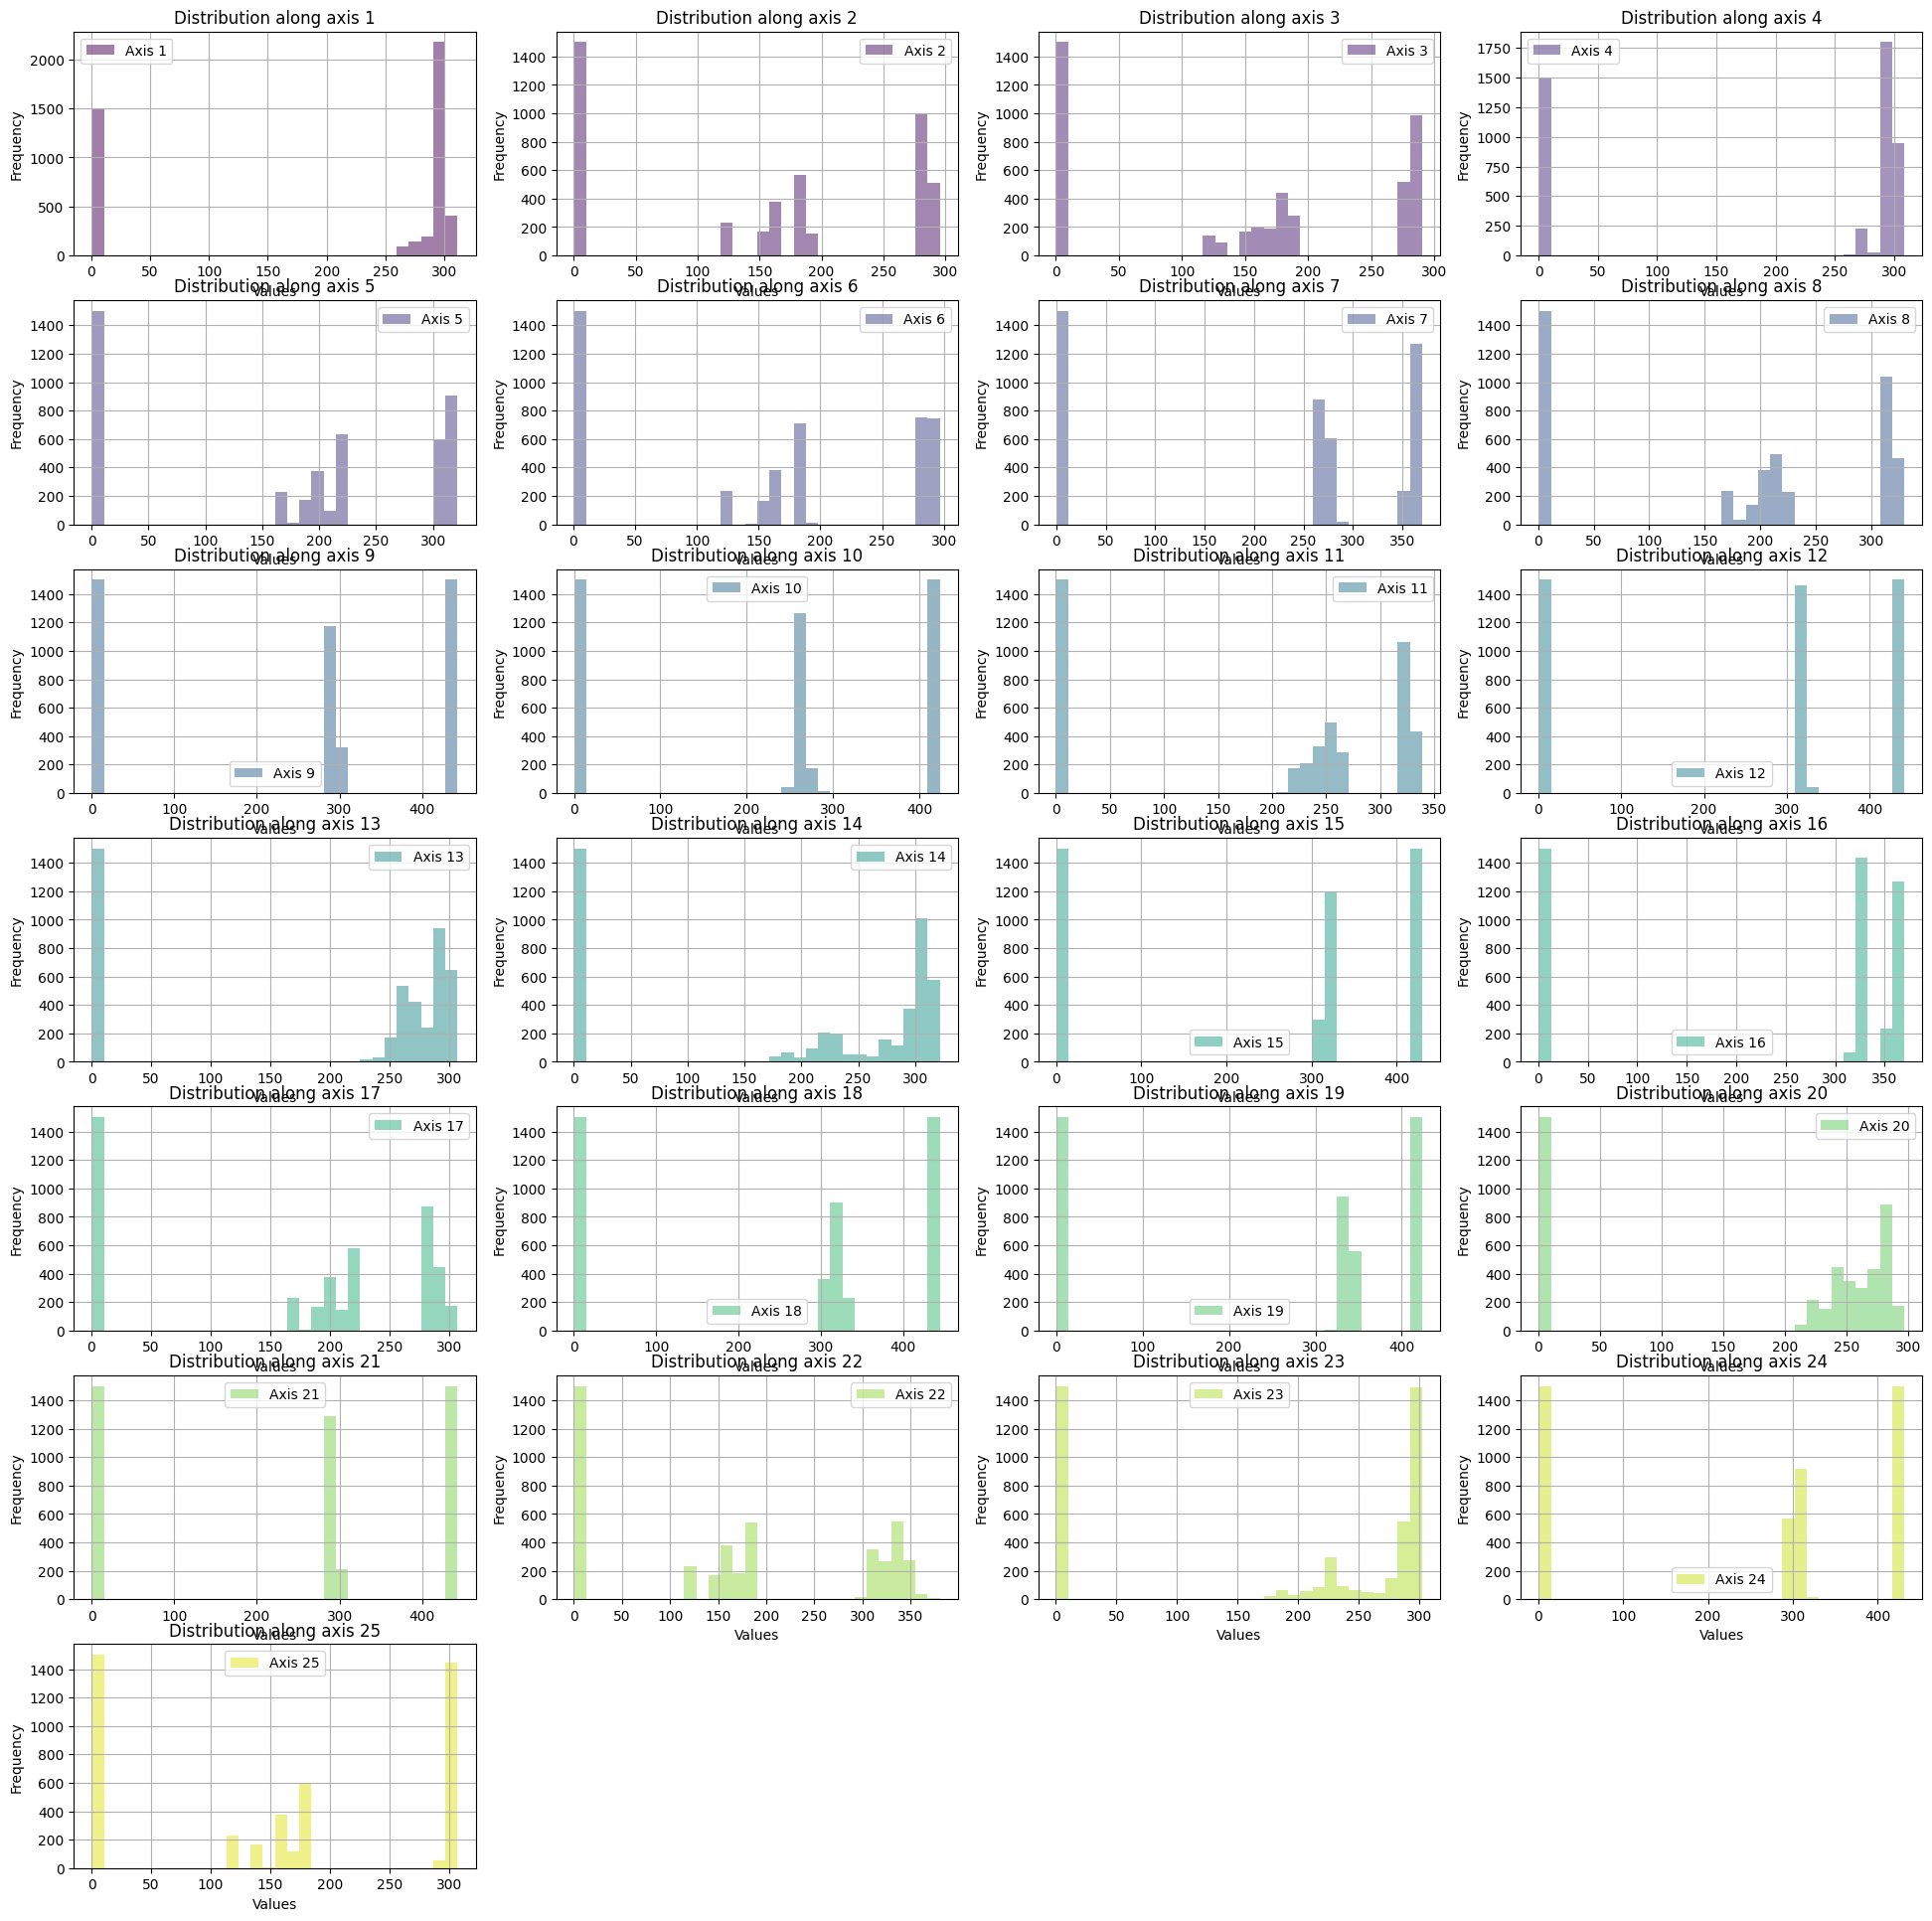

In [112]:
act_path_skel = find_all_path(r'a3', skeleton_list)
act_path_op = find_all_path(r'a4', skeleton_op_list)
merged_skel = merge_data(act_path_skel, axis = 2, key = 'd_skel').reshape((-1, 20))
merged_op = merge_data(act_path_op, axis = 0). reshape((-1, 25))
axis_plot(merged_op, axis = 1)
#axis_plot(merged_skel, axis = 1)
plt.show()

In [48]:
## load data 
inertial_data = 

(0.20803, 0.718701, 0.472873, 1.0)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Apply graph convolutional layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)



In [19]:
# Define your input shape
num_samples = 505
num_graphs = 32
num_nodes = 20
num_features = 3

# Create dummy input data (you need to replace this with your actual data)
# print(window_data.shape)
x = torch.tensor(window_data, dtype=torch.float)

# Define an adjacency matrix (you need to replace this with your actual adjacency matrix)
# For simplicity, let's assume a fully connected graph for each graph in the dataset
edge_index_list = [
    torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.int).t().contiguous() 
    for _ in range(num_samples)
]

# Create PyTorch Geometric data objects
data_list = [
    Data(x=x[i], edge_index=edge_index_list[i])
    for i in range(num_samples)
]
# print(data_list)
# # Initialize and forward pass through the GCN model for each data object
# model = GCN(input_dim, hidden_dim, output_dim)
# outputs = [model(data) for data in data_list]


In [18]:
import torch.optim as optim

# Define dimensions
num_samples = 505
num_graphs = 32
num_nodes = 20
num_features = 3
input_dim = num_features
hidden_dim = 64
output_dim = 2  # Output dimension depends on your task (e.g., classification)

# Initialize the model
model = GCN(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Iterate over the dataset
    for sample_idx in range(num_samples):
        # Generate input data (you need to replace this with your actual data)
        x = x[sample_idx]
        edge_index_list = [
            torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t().contiguous()
            for _ in range(num_graphs)
        ]
        data_list = [
            Data(x=x[i], edge_index=edge_index_list[i])
            for i in range(num_graphs)
        ]
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = [model(data) for data in data_list]
        outputs = torch.stack(outputs).reshape(num_graphs * num_nodes, output_dim)
        
        # Generate ground truth labels (you need to replace this with your actual labels)
        labels = torch.tensor(labels_dataset[sample_idx])
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}, Loss: {running_loss / num_samples}")

print("Finished Training")


NameError: name 'x' is not defined